# Partical Work 07 - Classification with Support Vector Machines (SVM)
- Author: *Romain Claret*
- Due-date: *05.11.2018*

## Exercice 1 Digit classification system using different SVM classifiers

### a) Getting the training and test sample sets from the MNIST database
a) Load MNIST

In [1]:
import pandas as pd
import os
import numpy as np

# This is a method to read the MNIST dataset from a ROOT directory
def load_MNIST(ROOT):
    train_nrows = 5000
    test_nrows = 1000
    '''load all of mnist training set first'''
    Xtr = []
    #train = pd.read_csv(os.path.join(ROOT, 'mnist_train.csv'), nrows = train_nrows)
    train = pd.read_csv(os.path.join(ROOT, 'mnist_train.csv'))
    X = np.array(train.drop('label', axis=1))
    Ytr = np.array(train['label'])
    # With this for-loop we give the data a shape of the acctual image (28x28)
    # instead of the shape in file (1x784)
    for row in X:
        Xtr.append(row.reshape(28,28))
    # load test set second
    Xte = []
    #test = pd.read_csv(os.path.join(ROOT, 'mnist_test.csv'), nrows = test_nrows)
    test = pd.read_csv(os.path.join(ROOT, 'mnist_test.csv'))
    X = np.array(test.drop('label', axis=1))
    Yte = np.array(test['label'])
    # same reshaping
    for row in X:
        Xte.append(row.reshape(28,28))

    return np.array(Xtr), np.array(Ytr), np.array(Xte), np.array(Yte)

# Load the raw MNIST data.
mnist_dir = './mnist'   # TODO: update this dir information to your own dir
X_train, y_train, X_test, y_test = load_MNIST(mnist_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


In [2]:
#from sklearn import svm
#clf_svm = svm.LinearSVC()
#clf_svm.fit(X_train, y_train)
#y_pred_svm = clf_svm.predict(X_test)
#acc_svm = accuracy_score(y_test, y_pred_svm)
#print("Linear SVM accuracy: ",acc_svm)

b) Visualize (plot)

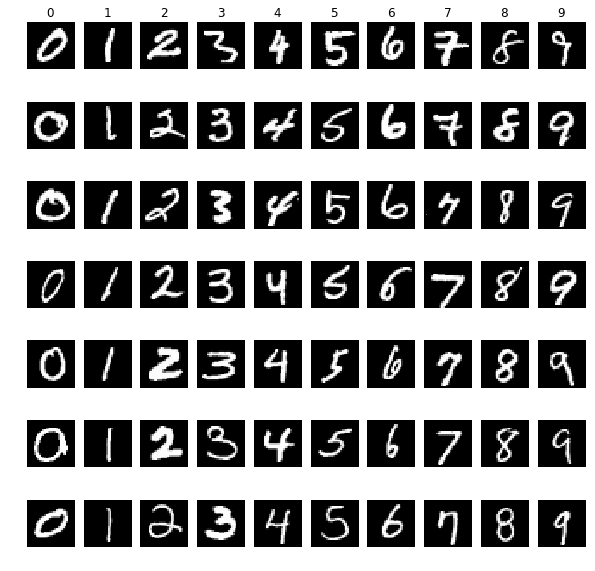

In [3]:
import matplotlib.pyplot as plt
    
# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window. Also setting some parameters for display.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Now let's visualise some of the images
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes): # y and cls takes values from 0-9
    idxs = np.flatnonzero(y_train == y) # gets the indices of samples that corresponds to class y
    idxs = np.random.choice(idxs, samples_per_class, replace=False) # picks randomly samples_per_class indices
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1   # determines the sub-plot index
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

c) Build the final training and test sets

In [4]:
# Subsample the data for more efficient code execution in this exercise. We do this to make it go faster. 
# When you will have completed the whole notebook, you can run it again on a larger (or total) dataset 
# and observe the difference in terms of accuracy (and speedup).
#X_train, y_train, X_test, y_test
#num_training = 200
#mask = range(num_training)
#X_train = X_train[mask]
#y_train = y_train[mask]

#num_test = 100
#mask = range(num_test)
#X_test = X_test[mask]
#y_test = y_test[mask]

#print('Training subsampled data shape: ', X_train.shape)
#print('Training subsampled labels shape: ', y_train.shape)
#print('Test subsampled data shape: ', X_test.shape)
#print('Test subsampled labels shape: ', y_test.shape)

from collections import defaultdict

def balance(X_data, y_data, samples=0):
    
    blanced_truth_min = samples
    if samples == 0: 
        truth_count = int()
        for y in range(len(y_data)):
            truth_count[y_data[y]] = truth_count[y_data[y]] + 1
        blanced_truth_min = truth_count[min(truth_count, key=truth_count.get)]
    
    index_list = defaultdict(list)
    index = []
    
    y_mask = list(range(len(y_data)))
    np.random.shuffle(y_mask)
    for y in y_mask:
        if len(index_list[y_data[y]]) < blanced_truth_min:
            index_list[y_data[y]].append(y)
            index.append(y)
    
    return index, blanced_truth_min

train_balanced_indices, n1 = balance(X_train, y_train, 200)
test_balanced_indices, n2 = balance(X_test, y_test, 100)

def X_train_balance():
    return [X_train[i] for i in train_balanced_indices]

def y_train_balance():
    return [y_train[i] for i in train_balanced_indices]

def X_test_balance():
    return [X_test[i] for i in test_balanced_indices]

def y_test_balance():
    return [y_test[i] for i in test_balanced_indices]

### b) Classification of digits based on raw pixel values using SVM and different kernels

a) http://scikit-learn.org/stable/modules/svm.html

In [6]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

y_train_balanced = y_train_balance()

X_train_balanced_dim_2 = []
X_train_balanced_dim_2_labels = []
for x in X_train_balance():
    X_tmp = []
    sorted_labels = sorted(x, key=lambda x: x[1], reverse=True)
    X_train_balanced_dim_2_labels.append(sorted_labels[0][0])
    for tmp in x:
        X_tmp.append(tmp[1])
    X_train_balanced_dim_2.append(X_tmp)

fold_size = 10

Cs = [10, 100, 1000]
gammas = [0.001, 0.01, 0.1, 1]
degrees = [1, 2, 3, 4]

linear_measures = []
linear_measures_cm = []
linear_measures_score = []

linear_cvs_measures = []
linear_cvs_measures_cm = []
linear_cvs_measures_score = []

rbf_measures = []
rbf_measures_cm = []
rbf_measures_score = []

poly_measures = []
poly_measures_cm = []
poly_measures_score = []

for c in Cs:
    # linear
    model = svm.SVC(kernel='linear', C=c, gamma='auto')
    model.fit(X_train_balanced_dim_2, y_train_balanced)
    res = np.mean(cross_val_score(model,
                                  X_train_balanced_dim_2,
                                  y_train_balanced,
                                  cv=fold_size))
    linear_measures.append(res)
    y_pred = model.predict(X_train_balanced_dim_2)
    linear_measures_cm.append(confusion_matrix(y_train_balanced, y_pred))
    linear_measures_score.append(model.score(X_train_balanced_dim_2, y_train_balanced))
    
    # linear cvs
    #model = svm.LinearSVC(C=1.0)
    model = svm.LinearSVC(C=c)
    model.fit(X_train_balanced_dim_2, y_train_balanced)
    res = np.mean(cross_val_score(model,
                                  X_train_balanced_dim_2,
                                  y_train_balanced,
                                  cv=fold_size))
    linear_cvs_measures.append(res)
    y_pred = model.predict(X_train_balanced_dim_2)
    linear_cvs_measures_cm.append(confusion_matrix(y_train_balanced, y_pred))
    linear_cvs_measures_score.append(model.score(X_train_balanced_dim_2, y_train_balanced))
    
    # rbf
    res = []
    for gamma in gammas:
        model = svm.SVC(kernel='rbf', gamma=gamma, C=c)
        res.append(np.mean(cross_val_score(model,
                                           X_train_balanced_dim_2,
                                           y_train_balanced,
                                           cv=fold_size)))
        #y_pred = model.predict(X_train_balanced_dim_2)
        #rbf_measures_cm.append(confusion_matrix(y_train_balanced, y_pred))
        #rbf_measures_score.append(model.score(X_train_balanced_dim_2, y_train_balanced))
    rbf_measures.append(res)
    
    # poly
    res = []
    for degree in degrees:
        model = svm.SVC(kernel='poly', degree=degree, C=c, gamma='auto')
        res.append(np.mean(cross_val_score(model,
                                           X_train_balanced_dim_2,
                                           y_train_balanced,
                                           cv=fold_size)))
        #y_pred = model.predict(X_train_balanced_dim_2)
        #poly_measures_cm.append(confusion_matrix(y_train_balanced, y_pred))
        #poly_measures.append(model.score(X_train_balanced_dim_2, y_train_balanced))
    poly_measures.append(res)


print("Cs:",Cs)
print("gammas:",gammas)
print("degrees:",degrees)
print("linear_measures: ", linear_measures)
print("linear_measures_score: ", linear_measures_score)
print("linear_cvs_measures: ", linear_cvs_measures)
print("linear_measures_score: ", linear_measures_score)
print("rbf_measures: ", rbf_measures)
print("poly_measures: ", poly_measures)

/anaconda3/envs/MachLe/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/MachLe/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/MachLe/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/MachLe/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/MachLe/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

Cs: [10, 100, 1000]
gammas: [0.001, 0.01, 0.1, 1]
degrees: [1, 2, 3, 4]
linear_measures:  [0.101, 0.101, 0.101]
linear_measures_score:  [0.1025, 0.1025, 0.1025]
linear_cvs_measures:  [0.101, 0.101, 0.101]
linear_measures_score:  [0.1025, 0.1025, 0.1025]
rbf_measures:  [[0.101, 0.101, 0.1015, 0.1015], [0.1015, 0.101, 0.1015, 0.1015], [0.101, 0.101, 0.1015, 0.1015]]
poly_measures:  [[0.101, 0.1005, 0.1005, 0.1005], [0.101, 0.1005, 0.1005, 0.1005], [0.101, 0.1005, 0.1005, 0.1005]]


b) http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

c) http://scikit-learn.org/stable/modules/grid_search.html

d) http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

e) http://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
and ...#classification-report

f) http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf

In [ ]:
c = 1000
gamma = 0.001
degree = 1

model = svm.SVC(kernel='linear', C=c)
model.fit(X_train_balanced_dim_2, y_train_balanced)
y_pred = model.predict(X_train_balanced_dim_2)
cm = confusion_matrix(y_train_balanced, y_pred)
score = model.score(X_train_balanced_dim_2, y_train_balanced)
print("linear score: ", score)
print("linear confusion_matrix:\n", cm)

model = svm.LinearSVC(C=c)
model.fit(X_train_balanced_dim_2, y_train_balanced)
y_pred = model.predict(X_train_balanced_dim_2)
cm = confusion_matrix(y_train_balanced, y_pred)
score = model.score(X_train_balanced_dim_2, y_train_balanced)
print("SVC score: ", score)
print("SVC confusion_matrix:\n", cm)

# RBF
model = svm.SVC(kernel='rbf', gamma=gamma, C=c)
model.fit(X_train_balanced_dim_2, y_train_balanced)
y_pred = model.predict(X_train_balanced_dim_2)
cm = confusion_matrix(y_train_balanced, y_pred)
score = model.score(X_train_balanced_dim_2, y_train_balanced)
print("RBF score: ", score)
print("RBF confusion_matrix:\n", cm)

# Poly
model = svm.SVC(kernel='poly', degree=degree, C=c, gamma='auto')
model.fit(X_train_balanced_dim_2, y_train_balanced)
y_pred = model.predict(X_train_balanced_dim_2)
cm = confusion_matrix(y_train_balanced, y_pred)
score = model.score(X_train_balanced_dim_2, y_train_balanced)
print("Poly score: ", score)
print("Poly confusion_matrix:\n", cm)

### c. (Optional) Impact of preprocessing and feature extraction

### d. Analysis of the results

#### a) Which kernel and parameters were used ?
Not sure.. Didn't have time to run a good amount batches. The results are all similar with a measure at 0.101 and a score at 0.101ish. Not looking that good. 

#### b) Which digit classes are the best/worse recognized against which ? Why ?
Not sure...

#### c) What is the impact of the sizes of the training and test sets on the classification performance ?
The calculation time. Based on the features wanted, the training set have to increase dramatically.

PS: Sorry again for this screw up... 